In [1]:
from detector_model import NorthernTracksDetectorModel
from backend.stan_generator import (
    StanGenerator, GeneratedQuantitiesContext, DataContext,
    FunctionsContext, Include, ForLoopContext, StanFileGenerator)
from backend.operations import AssignValue, FunctionCall
from backend.variable_definitions import ForwardVariableDef
from backend.parameterizations import LogParameterization
from backend.expression import StringExpression
import logging
logging.basicConfig(level=logging.WARN)
import pystan
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.stats


In [2]:
with StanFileGenerator("detector_model_test") as cg:   
    ntd = NorthernTracksDetectorModel()    
    cg.generate_files()
    

In [2]:
e_true_name = "e_trues"
e_reco_name = "e_recos"
true_dir_name = "true_dirs"
reco_zenith_name = "reco_zeniths"
with StanGenerator() as cg:

    with FunctionsContext() as fc:
        _ = Include("utils.stan")
        _ = Include("vMF.stan")

    with DataContext() as dc:
        e_true = ForwardVariableDef(e_true_name, "real[100]")
        e_reco = ForwardVariableDef(e_reco_name, "real[100]")
        true_dir = ForwardVariableDef(true_dir_name, "vector[3]")
        reco_zenith = ForwardVariableDef(reco_zenith_name, "vector[100]")

    with GeneratedQuantitiesContext() as gq:
        ntd = NorthernTracksDetectorModel()

        e_res_result = ForwardVariableDef("e_res", "vector[100]")
        eff_area = ForwardVariableDef("eff_area", "vector[100]")
        ang_res_result = ForwardVariableDef("ang_res_1E5", "vector[100]")
        ang_res_result2 = ForwardVariableDef("ang_res_1E6", "vector[100]")
        reco_dir = ForwardVariableDef("reco_dir", "vector[3]")
        
        
        with ForLoopContext(1, 100, "i") as fc:
       
            e_res_result["i"] << ntd.energy_resolution(1E5, e_reco["i"])  
            eff_area["i"] <<  ntd.effective_area(e_true["i"], true_dir)
            
            reco_dir << StringExpression(["[sin(",reco_zenith["i"], "), 0, cos(", reco_zenith["i"],")]'"])
            ang_res_result["i"] << ntd.angular_resolution(1E5, true_dir, reco_dir)
            ang_res_result2["i"] << ntd.angular_resolution(1E6, true_dir, reco_dir)
    model = cg.generate()

In [4]:
this_dir = os.path.abspath('')
sm = pystan.StanModel(
    model_code=model,
    include_paths=[os.path.join(this_dir, "../dev/statistical_model/4_tracks_and_cascades/stan/")],
    verbose=False)

(90, 100)

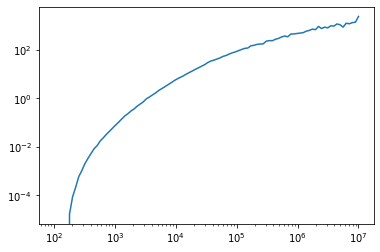

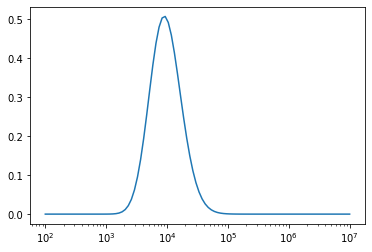

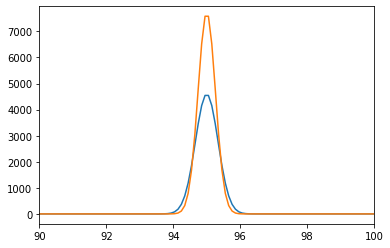

In [36]:
e_reco = np.logspace(2, 7, 100)
reco_zeniths = np.radians(np.linspace(90, 100, 100))
theta = np.radians(95)
data = {
    "e_trues": e_reco,
    "e_recos": e_reco,
    "true_dirs": [np.sin(theta), 0, np.cos(theta)],
    "reco_zeniths": reco_zeniths
    #"reco_dir": dir2
}
fit = sm.sampling(data=data, iter=1, chains=1, algorithm="Fixed_param")
plt.plot(e_reco, (fit.extract()["eff_area"].squeeze()))
plt.loglog()

plt.figure()
plt.plot(e_reco, np.exp(fit.extract()["e_res"].squeeze()))
plt.semilogx()

plt.figure()
plt.plot(np.degrees(reco_zeniths), np.exp(fit.extract()["ang_res_1E5"].squeeze()))
plt.plot(np.degrees(reco_zeniths), np.exp(fit.extract()["ang_res_1E6"].squeeze()))
plt.xlim(90, 100)
#plt.semilogx()
#plt.semilogy()
